## テスト用データを読み込んで顔抽出と予測結果を表示

In [27]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.5 MB/s eta 0:00:0000:0100:010m


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from face_rectangle_axis import get_face_rect
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#画像表示関数
def show_img(img):
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

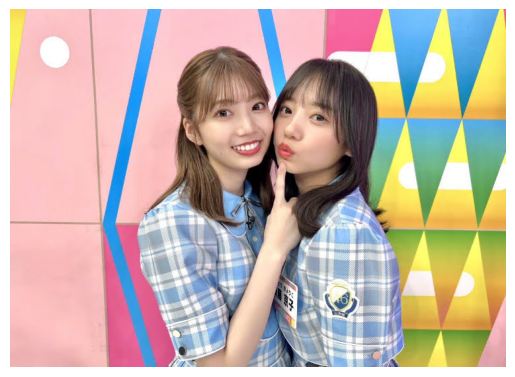

In [3]:
#画像読み込み
filename="./images/kyonko_test/kyonko_otake.jpg"
input_img=cv2.imread(filename)
show_img(input_img)

In [4]:
#顔部分検出
im, d=get_face_rect(filename)

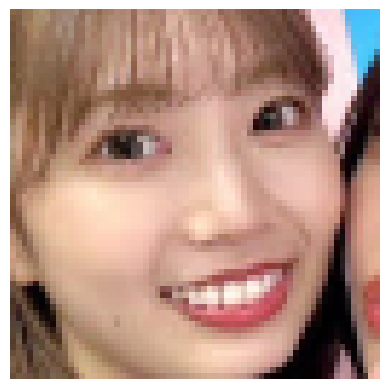

In [5]:
#顔部分表示
show_img(im[0])

In [15]:
#テンソル化
totensor=transforms.ToTensor()
tensor=totensor(im[0])

#正規化
norm=transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
tensor_img=norm(tensor)
tensor_img.size()

torch.Size([3, 64, 64])

In [16]:
#モデルのアーキテクチャを定義
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,16,5) #畳み込み層：入力チャネル数、フィルタ数、フィルタサイズ
        self.pool=nn.MaxPool2d(2,2) #プーリング層：領域のサイズ、ストライド
        self.conv2=nn.Conv2d(16,16,5)
        self.fc1=nn.Linear(16*29*29, 256)
        self.dropout=nn.Dropout(0.5)
        self.fc2=nn.Linear(256,5)
  
    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*29*29)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net=Net()
# net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)


In [39]:
#モデルのパラメータを読み込み
path="./pytorch_5member.pth"
device = 'cpu'

model = Net().to(device)
model.load_state_dict(torch.load(path))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
#データセット、データローダを用意する
totensor=transforms.ToTensor()
norm=transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
transform=transforms.Compose([totensor, norm])
input_dataset=ImageFolder("./images/kyonko_test/", transform)

inuput_loader=DataLoader(input_dataset, batch_size=1, shuffle=True)
dataiter = iter(input_loader)
images, labels = dataiter.next()  # サンプルを1つだけ取り出す

In [ ]:
#モデルより予測
net.eval()  # 評価モード
x, t = images, labels  
y = net(x)


In [ ]:
#結果の出力
plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

member_classes=np.array(["hono", "katoshi", "kyonko", "otake", "rena"])
print("正解:", member_classes[labels[0]], "予測結果:", member_classes[y.argmax().item()])